1. Понимание бизнеса
1.1 Цель
Прогнозирование качества вина

1.2 Описание
Два набора данных относятся к красному и белому вариантам португальского вина «Vinho Verde». Ссылка [Cortez et al., 2009]. Из соображений конфиденциальности и логистики доступны только физико-химические (входные) и органолептические (выходные) переменные (например, нет данных о сортах винограда, марке вина, продажной цене вина и т. д.).

2. Data Understanding
2.1 Import Libraries

In [412]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

2.2 Вспомогательные функции

In [413]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

2.3 Загрузка данных

In [414]:
data = pd.read_csv('winequalityN.csv')


2.4 Статистика и визуализации

In [415]:
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Входные параметры (на основе физико-химических тестов):
1 - фиксированная кислотность
2 - летучая кислотность
3 - лимонная кислота
4 - остаточный сахар
5 - хлориды
6 - свободный диоксид серы
7 - общий диоксид серы
8 - плотность
9 - рН
10 - сульфаты
11 - спирт
Выходная переменная (на основе сенсорных данных):
12 - качество (оценка от 0 до 10)

2.4.1 Далее взглянем на некоторую ключевую информацию о переменных

In [416]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [417]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

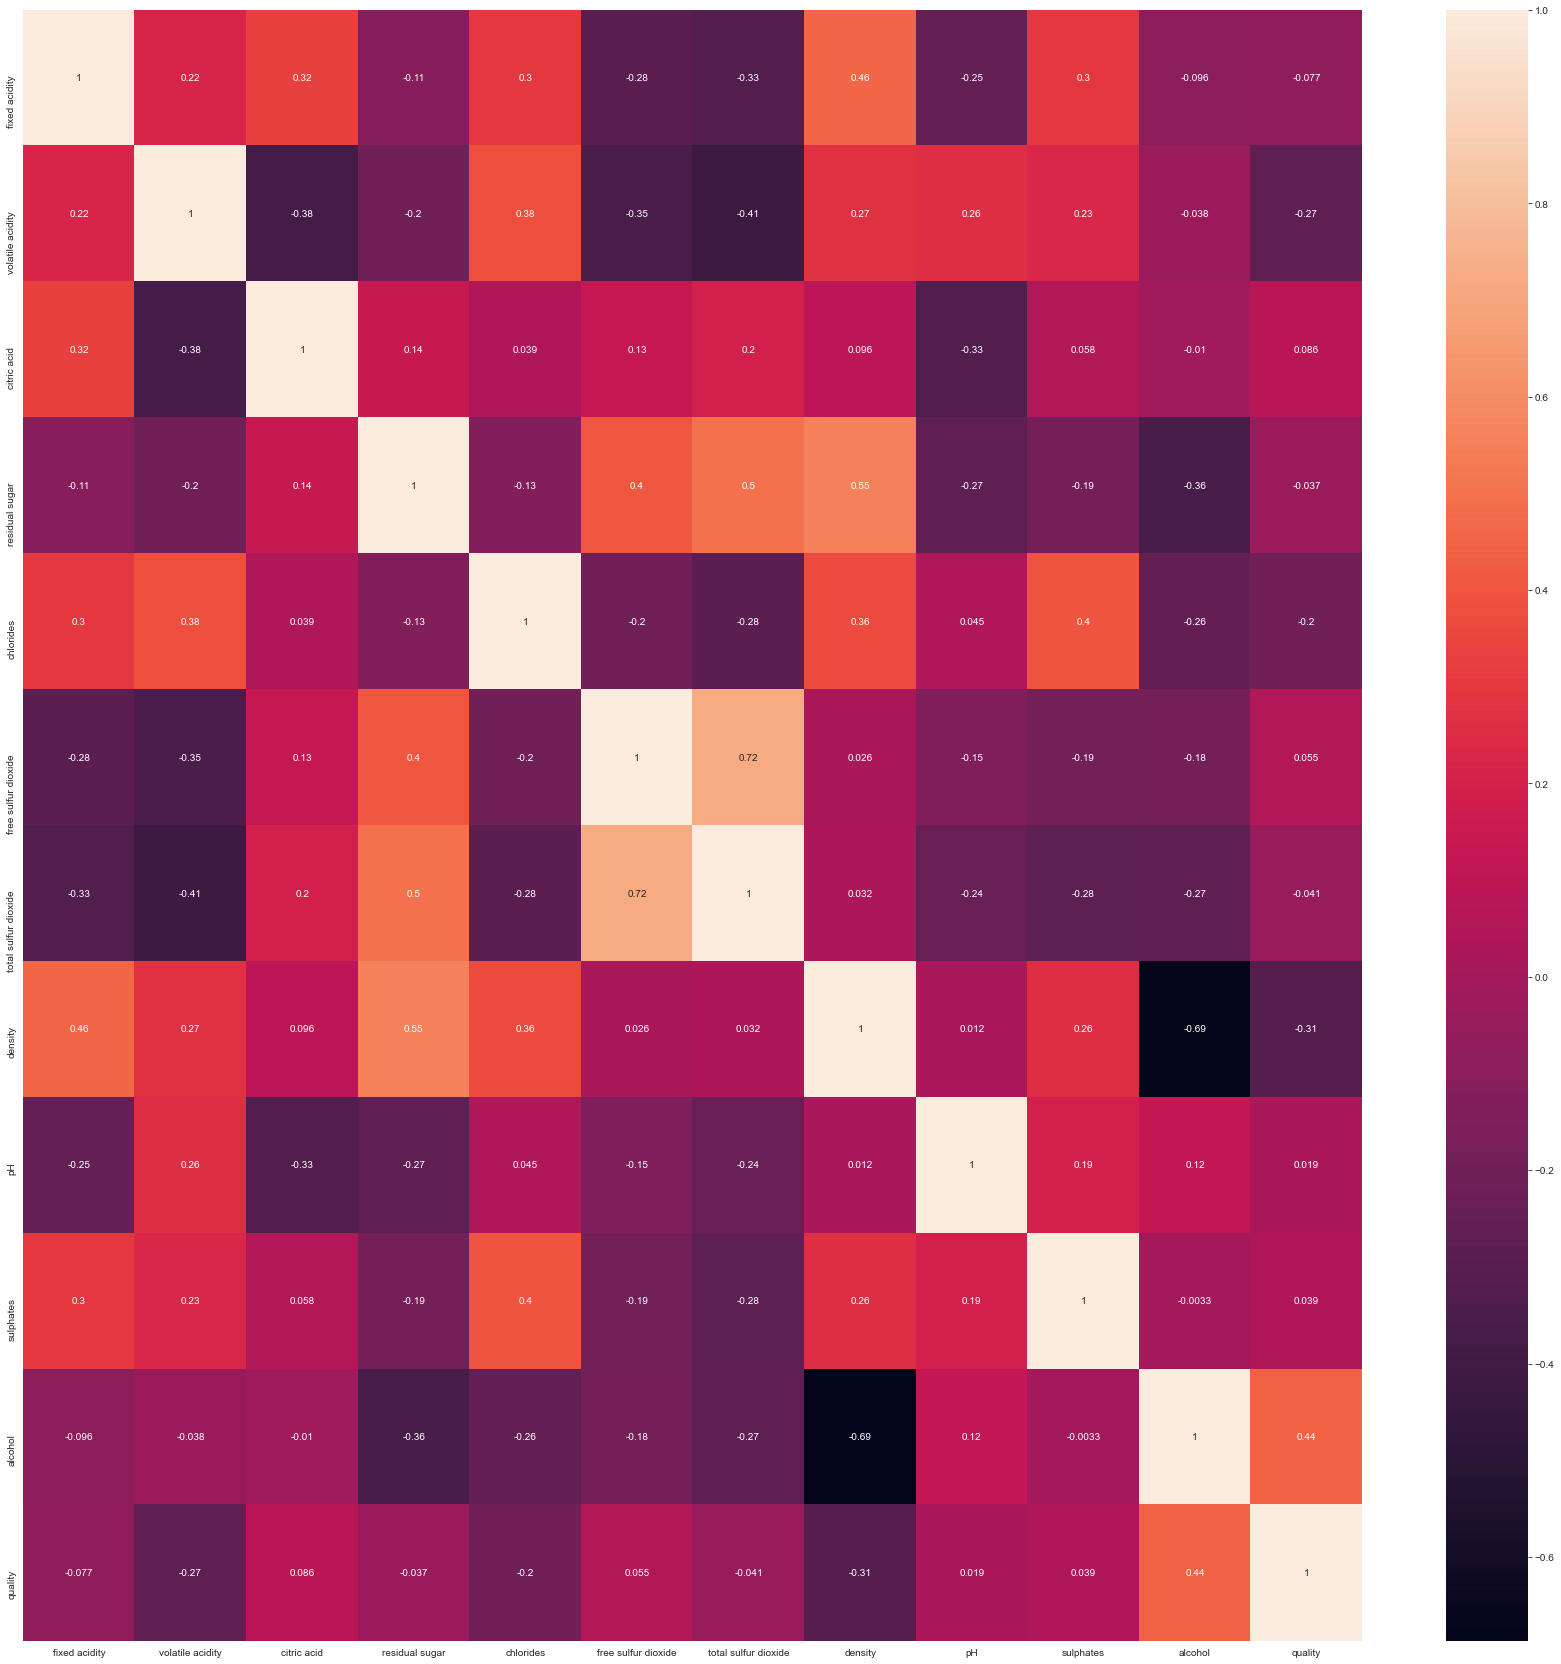

In [418]:
corr = data.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr,annot=True)
plt.show()

2.4.3 Давайте подробнее рассмотрим взаимосвязь между признаками
Начнем с рассмотрения взаимосвязи обьемной доли алкоголя и качества.

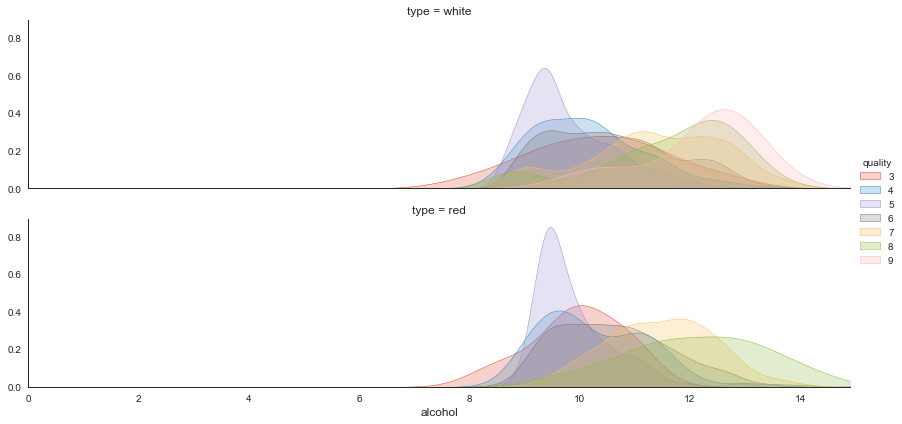

In [419]:
plot_distribution( data , var = 'alcohol' , target = 'quality' , row = 'type' )

Различия между качеством для разных значений - это то, что будет использоваться для разделения целевой переменной  в модели. Если бы две линии были примерно одинаковыми, то это не было бы хорошей переменной для нашей прогностической модели.

<AxesSubplot:>

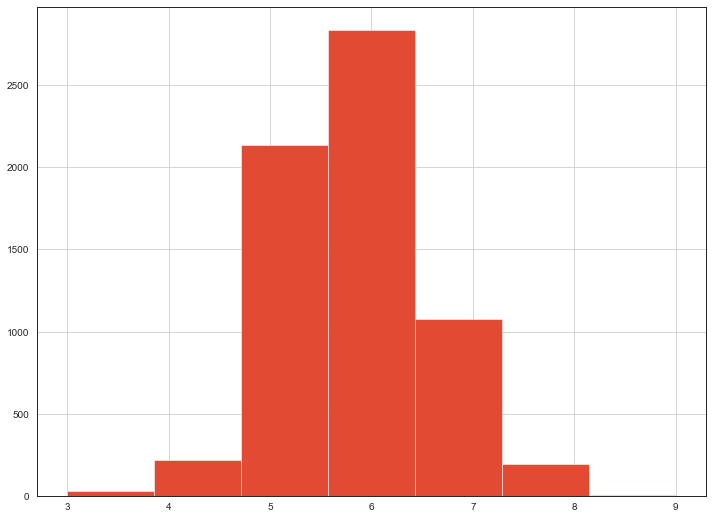

In [420]:
data['quality'].hist(bins=7, figsize=(12,9))

<AxesSubplot:>

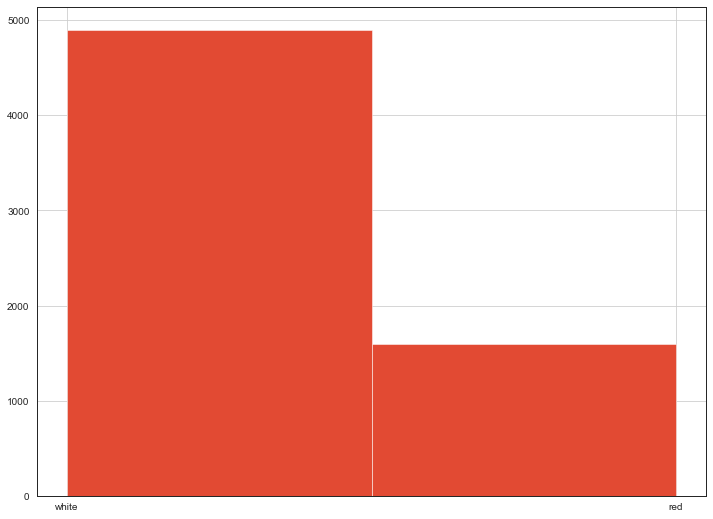

In [421]:
data['type'].hist(bins=2, figsize=(12,9))

Видим, что в данных есть перекос данных в один тип вина

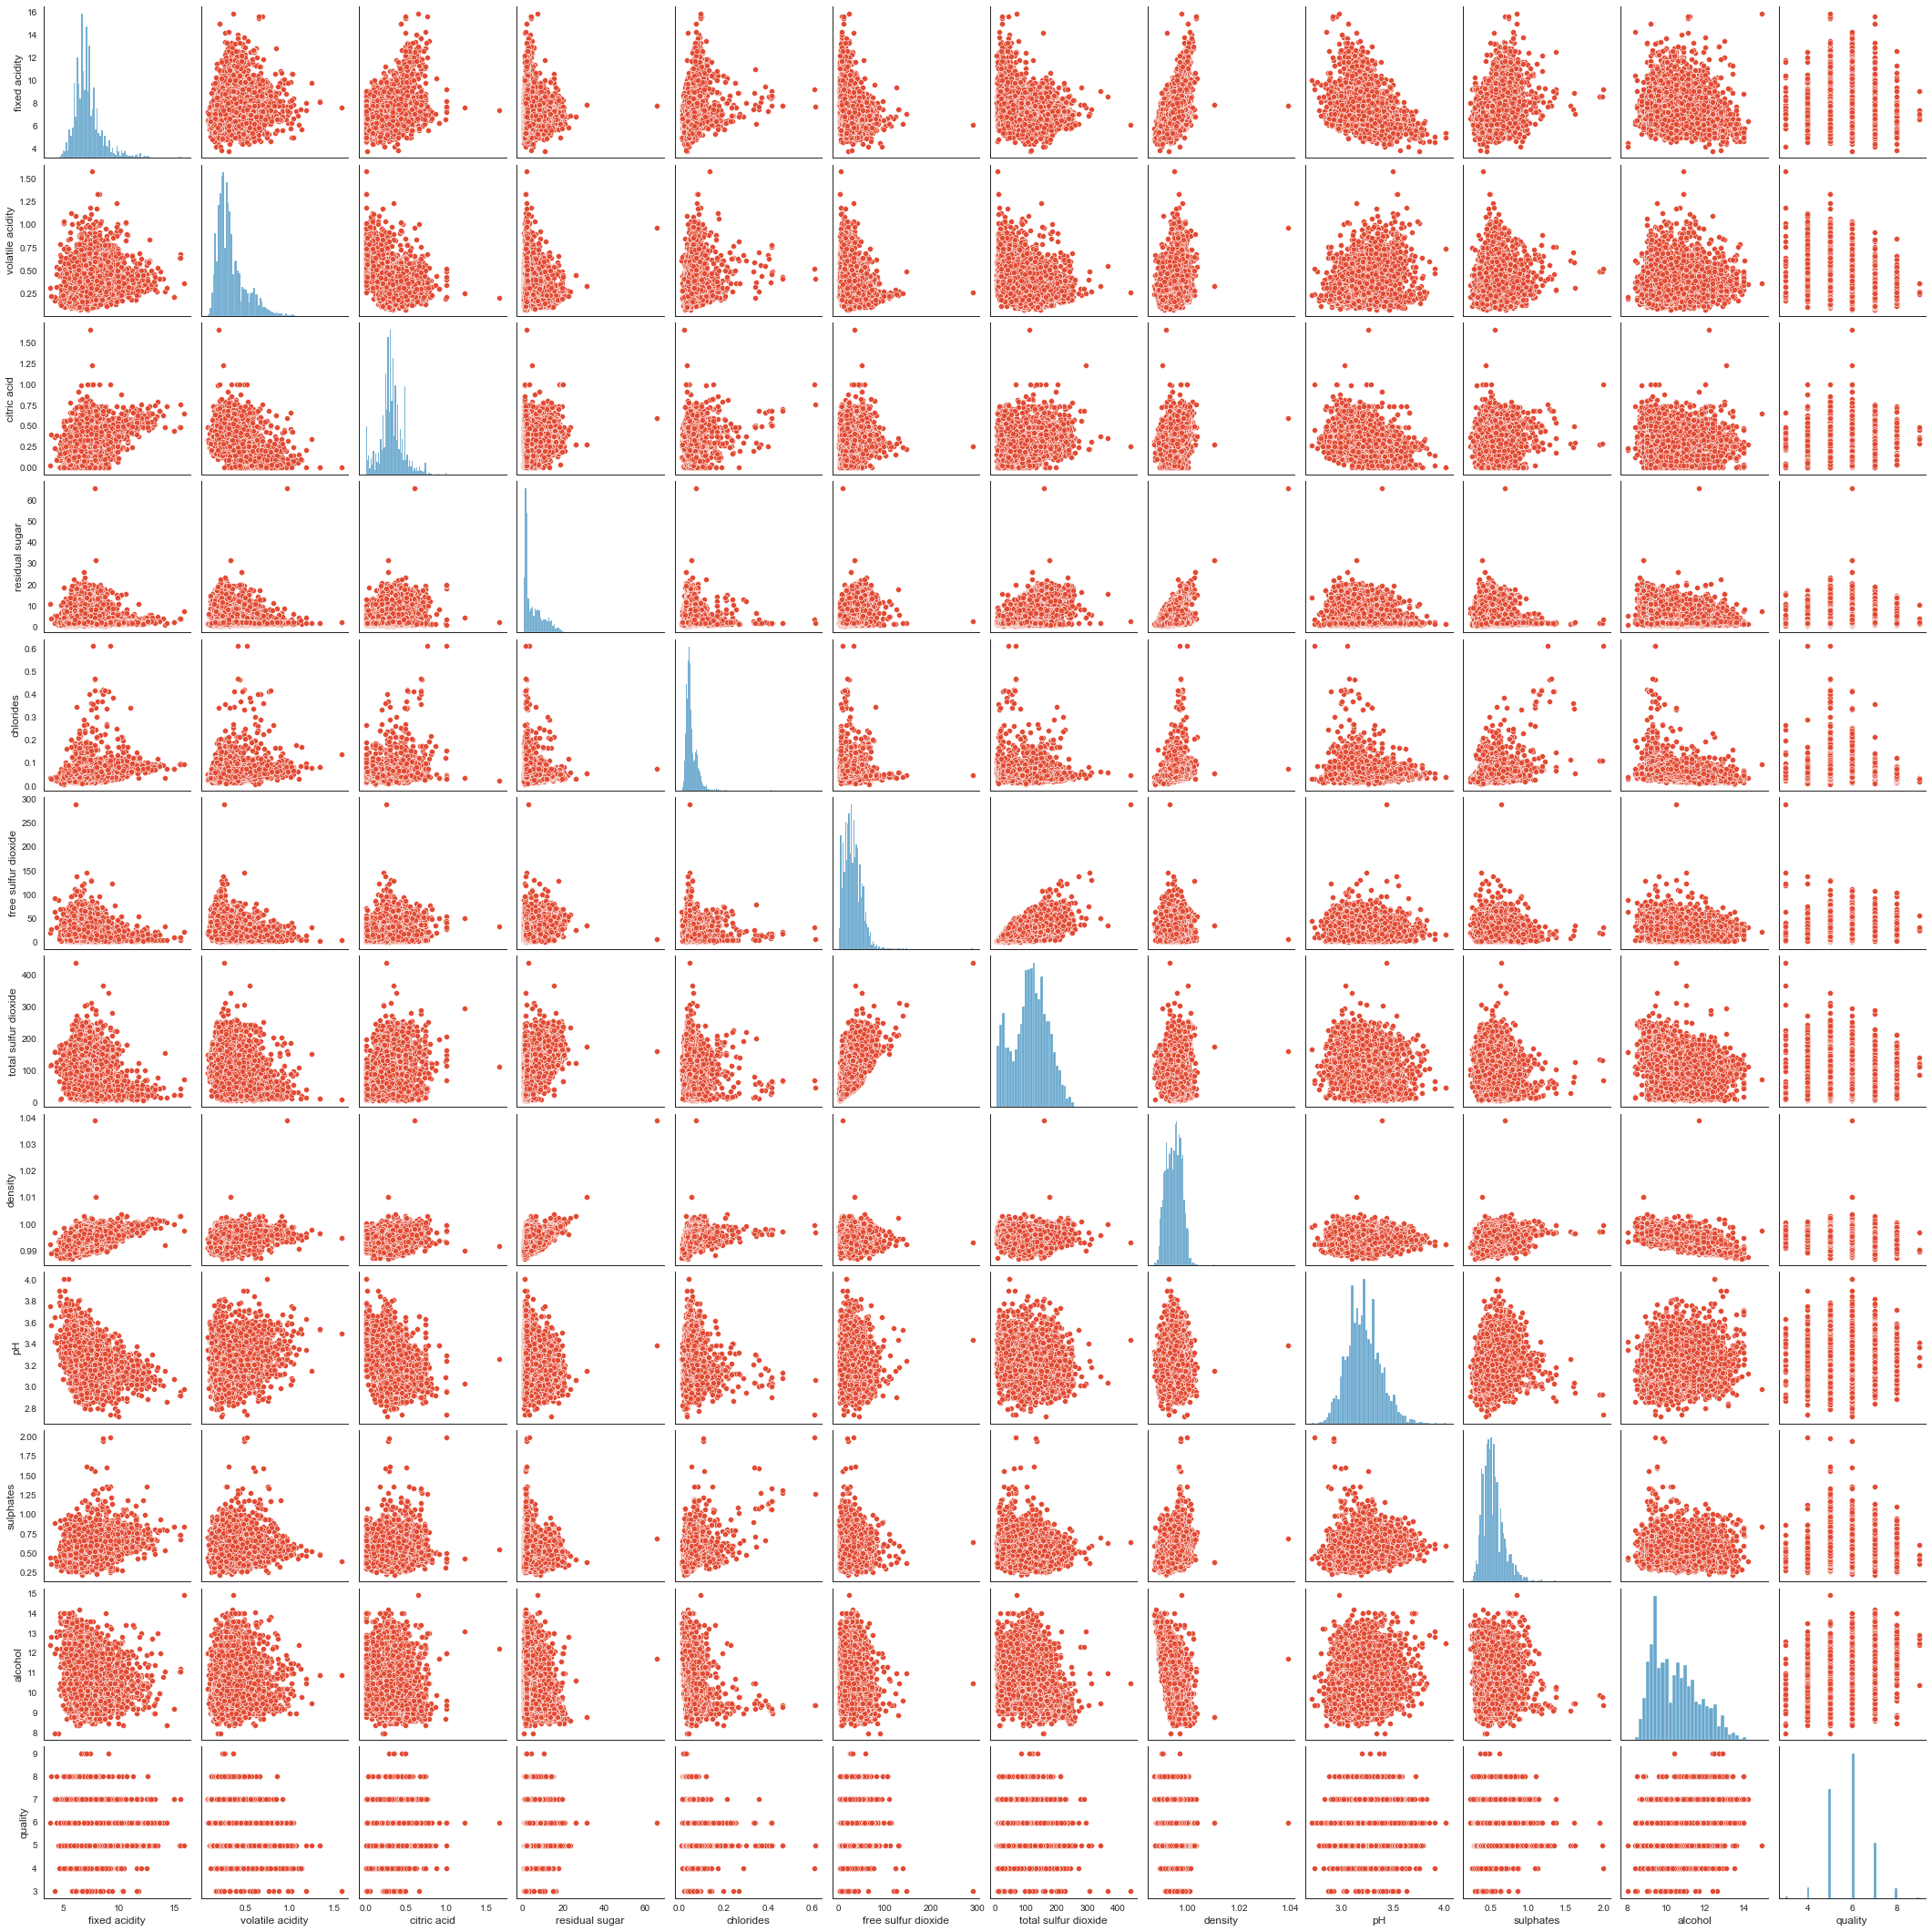

In [422]:
sns.pairplot(data)

In [423]:
numerical_columns = list(data.select_dtypes(exclude='object').columns)

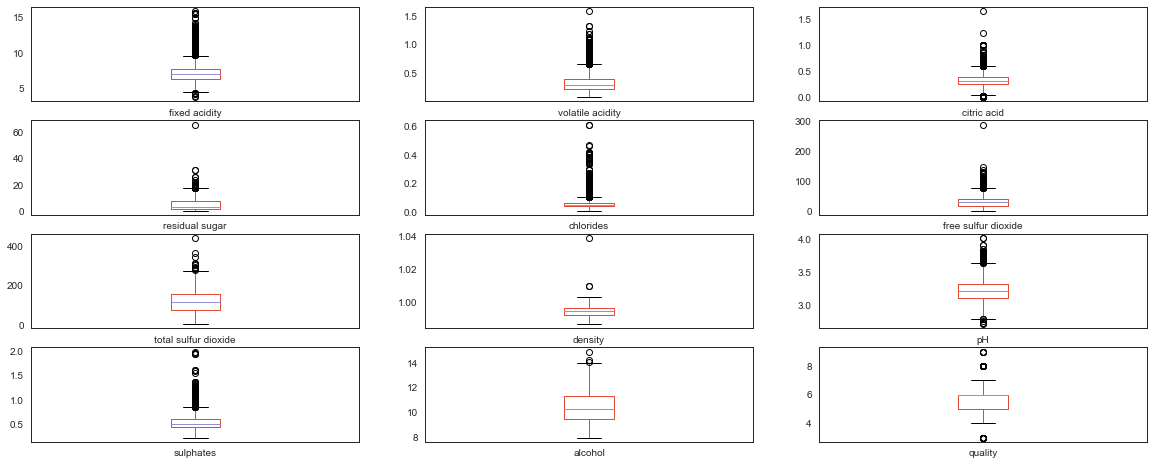

In [424]:
data[numerical_columns].plot(kind='box', subplots=True, layout=(4,3), legend=True, figsize=(20,8))
plt.show()

3. Data Preparation

3.1 Категориальные переменные должны быть преобразованы в числовые переменные
Переменные type рассматриваются как категориальные переменные. Некоторые из алгоритмов могут обрабатывать только числовые значения, поэтому нам нужно создать новую (фиктивную) переменную для каждого уникального значения категориальных переменных (OneHotEncoding)

In [425]:
data = pd.get_dummies (data, columns = ['type'])
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


3.2 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Если пропусков мало, можно удалить строки где присутсвует пропуск.

In [426]:
for word in numerical_columns:
    data = data[pd.isnull(data[word]) == 0 ]

In [427]:

data = data.reset_index(drop=True)
data.info()
data2 = data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6463 entries, 0 to 6462
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6463 non-null   float64
 1   volatile acidity      6463 non-null   float64
 2   citric acid           6463 non-null   float64
 3   residual sugar        6463 non-null   float64
 4   chlorides             6463 non-null   float64
 5   free sulfur dioxide   6463 non-null   float64
 6   total sulfur dioxide  6463 non-null   float64
 7   density               6463 non-null   float64
 8   pH                    6463 non-null   float64
 9   sulphates             6463 non-null   float64
 10  alcohol               6463 non-null   float64
 11  quality               6463 non-null   int64  
 12  type_red              6463 non-null   uint8  
 13  type_white            6463 non-null   uint8  
dtypes: float64(11), int64(1), uint8(2)
memory usage: 618.7 KB


После преобразования пропало только 33 строки данных

Также удаляем строки с выбрасами по данным

In [428]:
def outlier_removal(feature):
    Q1 = data[feature].quantile(0.25)
    Q2 = data[feature].quantile(0.75)
    IQR = Q2 - Q1
    upper = Q2 + (1.5*IQR)
    lower = Q1 - (1.5*IQR)
    new =  data[(data[feature]>=lower) & (data[feature]<=upper)]
    return new

In [429]:
for word in numerical_columns:
    data = outlier_removal(word) 
   

In [430]:
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4395 entries, 0 to 4394
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4395 non-null   float64
 1   volatile acidity      4395 non-null   float64
 2   citric acid           4395 non-null   float64
 3   residual sugar        4395 non-null   float64
 4   chlorides             4395 non-null   float64
 5   free sulfur dioxide   4395 non-null   float64
 6   total sulfur dioxide  4395 non-null   float64
 7   density               4395 non-null   float64
 8   pH                    4395 non-null   float64
 9   sulphates             4395 non-null   float64
 10  alcohol               4395 non-null   float64
 11  quality               4395 non-null   int64  
 12  type_red              4395 non-null   uint8  
 13  type_white            4395 non-null   uint8  
dtypes: float64(11), int64(1), uint8(2)
memory usage: 420.7 KB


3.3 Feature Engineering – добавляем новые признаки

Видим, что есть перекос данных в отношение одного типа вина. Повторяем данные с недостающим типом для выравнивания количества.

In [431]:
ind_1 = data[data['type_red']==1].index
ind_2 = data[data['type_white']==1].index


In [432]:
df = data.copy()
dat = data.copy()

In [433]:
for i in range(0,len(ind_2)-len(ind_1)):
    d=np.random.choice(ind_1,1)
    df=df.append(data[d[0]:d[0]+1], ignore_index=True)


In [434]:
df = df.reset_index(drop=True)
df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8090 entries, 0 to 8089
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         8090 non-null   float64
 1   volatile acidity      8090 non-null   float64
 2   citric acid           8090 non-null   float64
 3   residual sugar        8090 non-null   float64
 4   chlorides             8090 non-null   float64
 5   free sulfur dioxide   8090 non-null   float64
 6   total sulfur dioxide  8090 non-null   float64
 7   density               8090 non-null   float64
 8   pH                    8090 non-null   float64
 9   sulphates             8090 non-null   float64
 10  alcohol               8090 non-null   float64
 11  quality               8090 non-null   int64  
 12  type_red              8090 non-null   uint8  
 13  type_white            8090 non-null   uint8  
dtypes: float64(11), int64(1), uint8(2)
memory usage: 774.4 KB


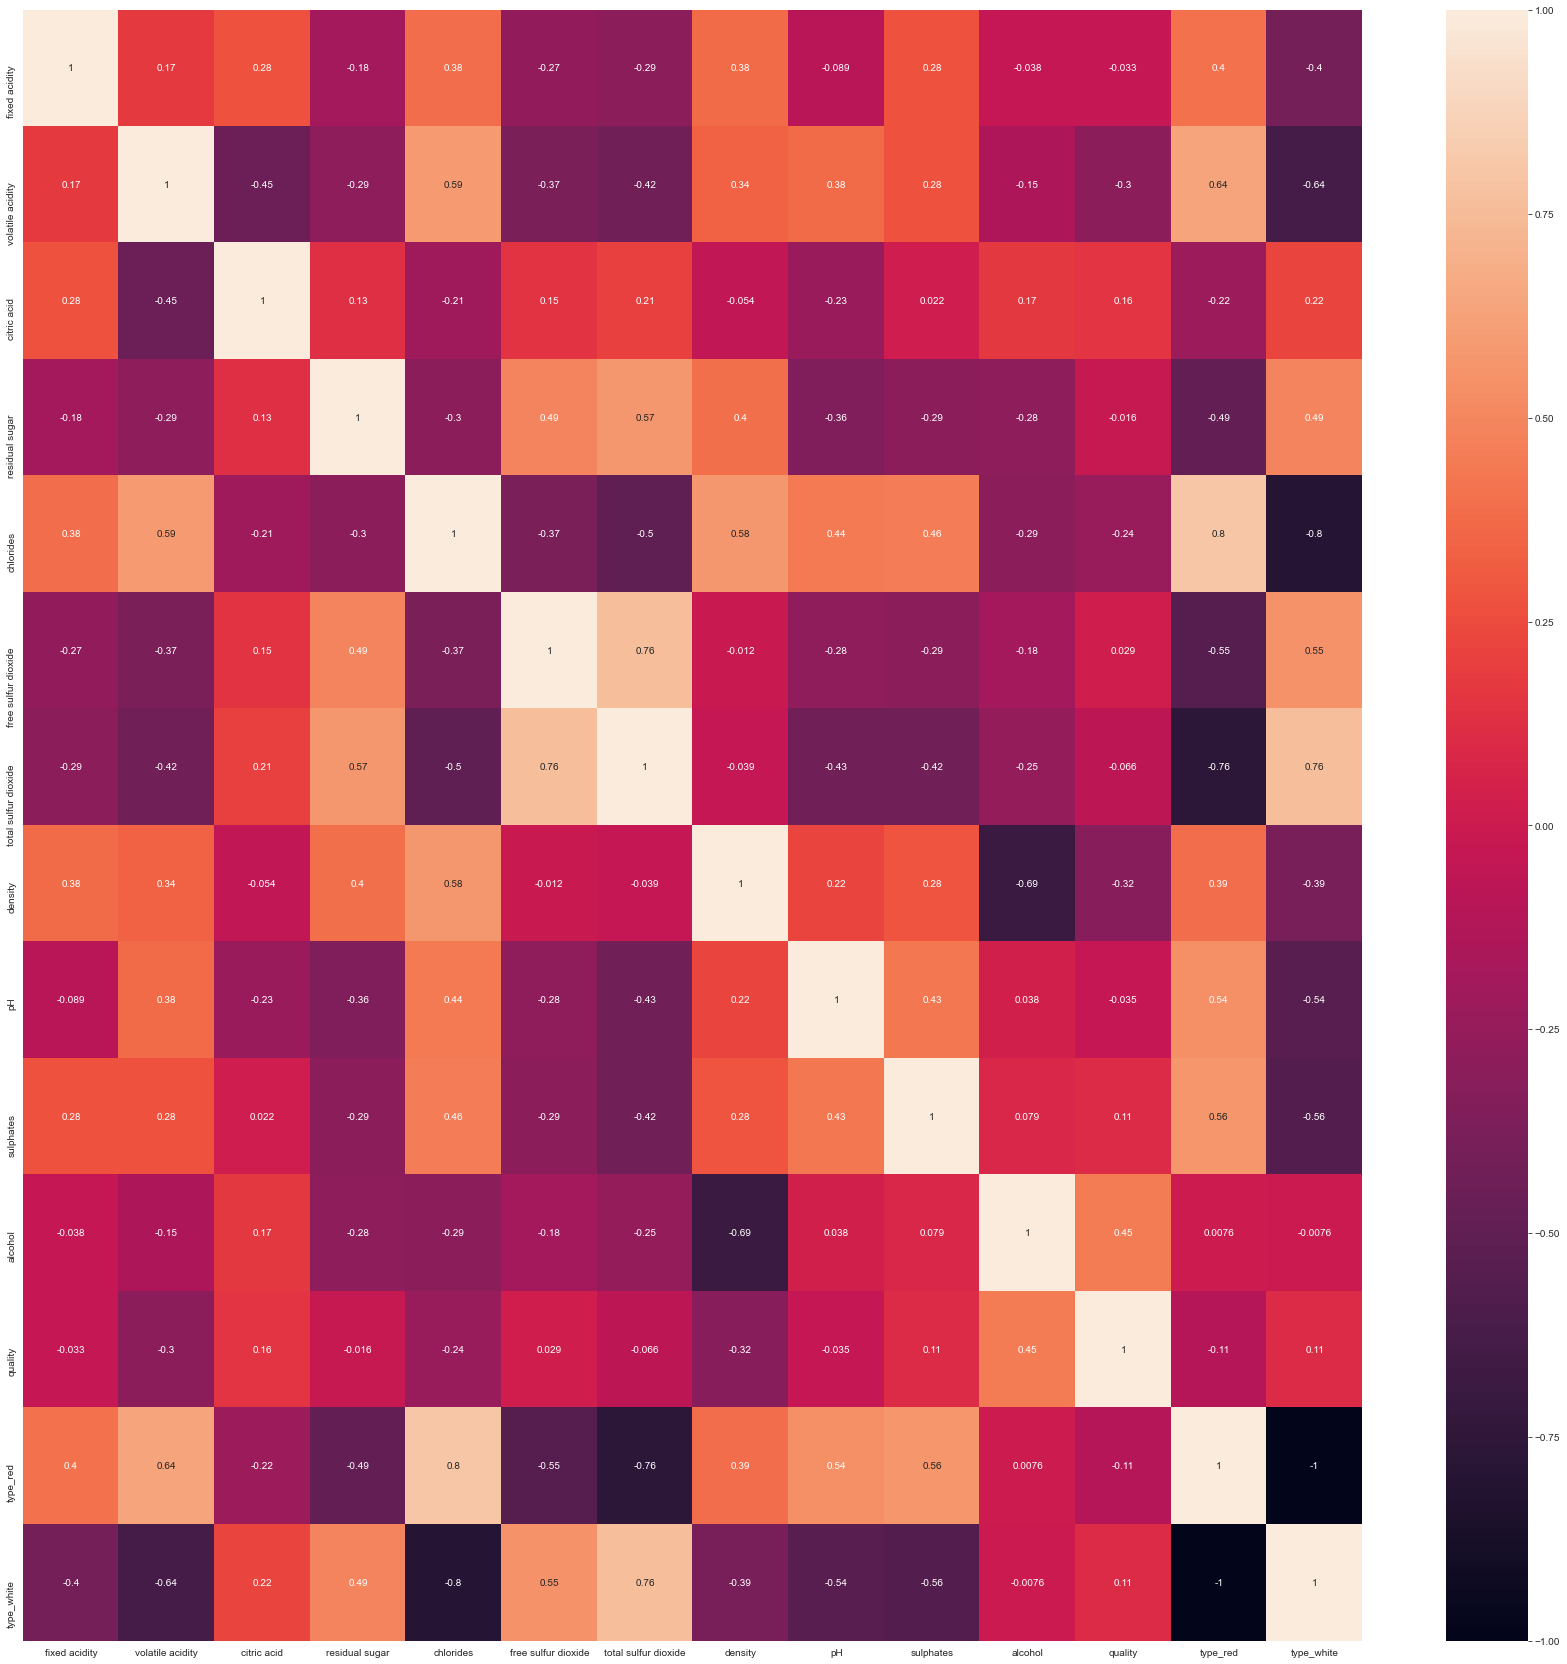

In [435]:
corr = df.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr,annot=True)
plt.show()

3.4 Сборка финальных датасетов для моделирования

3.4.1 Variable selection
type  
fixed acidity
volatile acidity
citric acid
residual sugar
chlorides  
free sulfur dioxide
total sulfur dioxide
density
pH 
sulphates 
alcohol 


отбор признаков на основе feature_impotance от алгоритма RandomForest

In [436]:
Y = dat['quality']
del dat['quality']
X = dat.copy()

In [437]:
model = RandomForestClassifier()
model.fit(X, Y) # обучение
for i in range(0,13):
    print(f"{i}\t- {model.feature_importances_[i]:.4f}")

0	- 0.0749
1	- 0.0950
2	- 0.0787
3	- 0.0867
4	- 0.0827
5	- 0.0910
6	- 0.0931
7	- 0.1070
8	- 0.0857
9	- 0.0816
10	- 0.1196
11	- 0.0020
12	- 0.0019


3.4.2 Создание датасетов

In [438]:
Y = df['quality']
del df['quality']
X = df.copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [439]:
norm = MinMaxScaler()
norm_fit = norm.fit(X_train)
new_Xtrain = norm_fit.transform(X_train)
new_Xtest = norm_fit.transform(X_test)

4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

4.1 Выбор модели


In [440]:
tree_model = RandomForestClassifier(max_depth=30,n_estimators=200,random_state=0)
tree_model.fit(new_Xtrain, Y_train)

RandomForestClassifier(max_depth=30, n_estimators=200, random_state=0)

In [441]:
print (tree_model.score( new_Xtrain ,  Y_train ) , tree_model.score( new_Xtest , Y_test ))

1.0 0.8559950556242274


6. Развертывание
Развертывание в данном означает публикацию полученного прогноза в таблицу на GitHub.

In [442]:
Y_p = data2['quality']
del data2['quality']
X_p = data2.copy()

In [443]:
Y_predict = tree_model.predict(X_p)
data2['predict'] = Y_predict
data2.head()
data2.to_csv( 'wine.csv' , index = False )